https://youtu.be/nCMDZEScF-4

**Nuclei segmentation in whole slide H&E images**

using pre-trained StarDist model.

This is pretty much all taken from Dr. Sreenivas Bhattiprolu's github:
https://github.com/bnsreenu/python_for_microscopists/blob/master/281_Segmenting_WSI_using_StarDist.ipynb

In [82]:
!pip install stardist
!pip install tensorflow

In [83]:
# To read Tiff files on Colab we need to install imagecodecs library
!pip install imagecodecs  

In [84]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [85]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [86]:
import os

pth = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3'  # path of ndpi files
WSIs = [_ for _ in os.listdir(pth) if _.endswith('ndpi')]

pth_mat = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\10x\matfiles'
crop_mats = [_ for _ in os.listdir(pth_mat) if _.endswith('mat')]

In [87]:
WSIs

['monkey_fetus_40_0371_Lung.ndpi',
 'monkey_fetus_40_0431_GI.ndpi',
 'monkey_fetus_40_0451_kidney.ndpi',
 'monkey_fetus_40_0507_Thyroid.ndpi',
 'monkey_fetus_40_0519_Ganglion.ndpi',
 'monkey_fetus_40_0532_heart.ndpi',
 'monkey_fetus_40_0612_brain.ndpi',
 'monkey_fetus_40_0640_bone.ndpi',
 'monkey_fetus_40_0642_bone2.ndpi']

In [88]:
imgs = []

# you might need to run "pip install imagecodecs" if you get jpeg compression error

for file in WSIs:
    print(os.path.join(pth,file))
    im = imread(os.path.join(pth,file))
    imgs.append(im)

\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_40_0371_Lung.ndpi
\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_40_0431_GI.ndpi
\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_40_0451_kidney.ndpi
\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_40_0507_Thyroid.ndpi
\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_40_0519_Ganglion.ndpi
\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_40_0532_heart.ndpi
\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_40_0612_brain.ndpi
\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_40_0640_bone.ndpi
\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\monkey_fetus_4

In [89]:
WSIs

['monkey_fetus_40_0371_Lung.ndpi',
 'monkey_fetus_40_0431_GI.ndpi',
 'monkey_fetus_40_0451_kidney.ndpi',
 'monkey_fetus_40_0507_Thyroid.ndpi',
 'monkey_fetus_40_0519_Ganglion.ndpi',
 'monkey_fetus_40_0532_heart.ndpi',
 'monkey_fetus_40_0612_brain.ndpi',
 'monkey_fetus_40_0640_bone.ndpi',
 'monkey_fetus_40_0642_bone2.ndpi']

In [90]:
for img in imgs:
    print(img.shape)

(29568, 36480, 3)
(28160, 36480, 3)
(28160, 38400, 3)
(26752, 38400, 3)
(28160, 38400, 3)
(26752, 38400, 3)
(25344, 36480, 3)
(25344, 36480, 3)
(25344, 38400, 3)


In [91]:
from scipy.io import loadmat

def get_crop_info(crop_mat_file_path, ratio) -> tuple:
    data = loadmat(crop_mat_file_path)

    crop_width = 256
    crop_height = crop_width
    crop_x = int(data['crop_x']*ratio)
    crop_y = int(data['crop_y']*ratio)

    return (crop_x, crop_y, crop_width)



In [92]:
ind = 0

mat_file_path = os.path.join(pth_mat, crop_mats[ind])
res20x=0.4416
res10x=1
ratio = res10x/res20x

crop_x, crop_y, tile_size = crop_info = get_crop_info(mat_file_path, ratio)

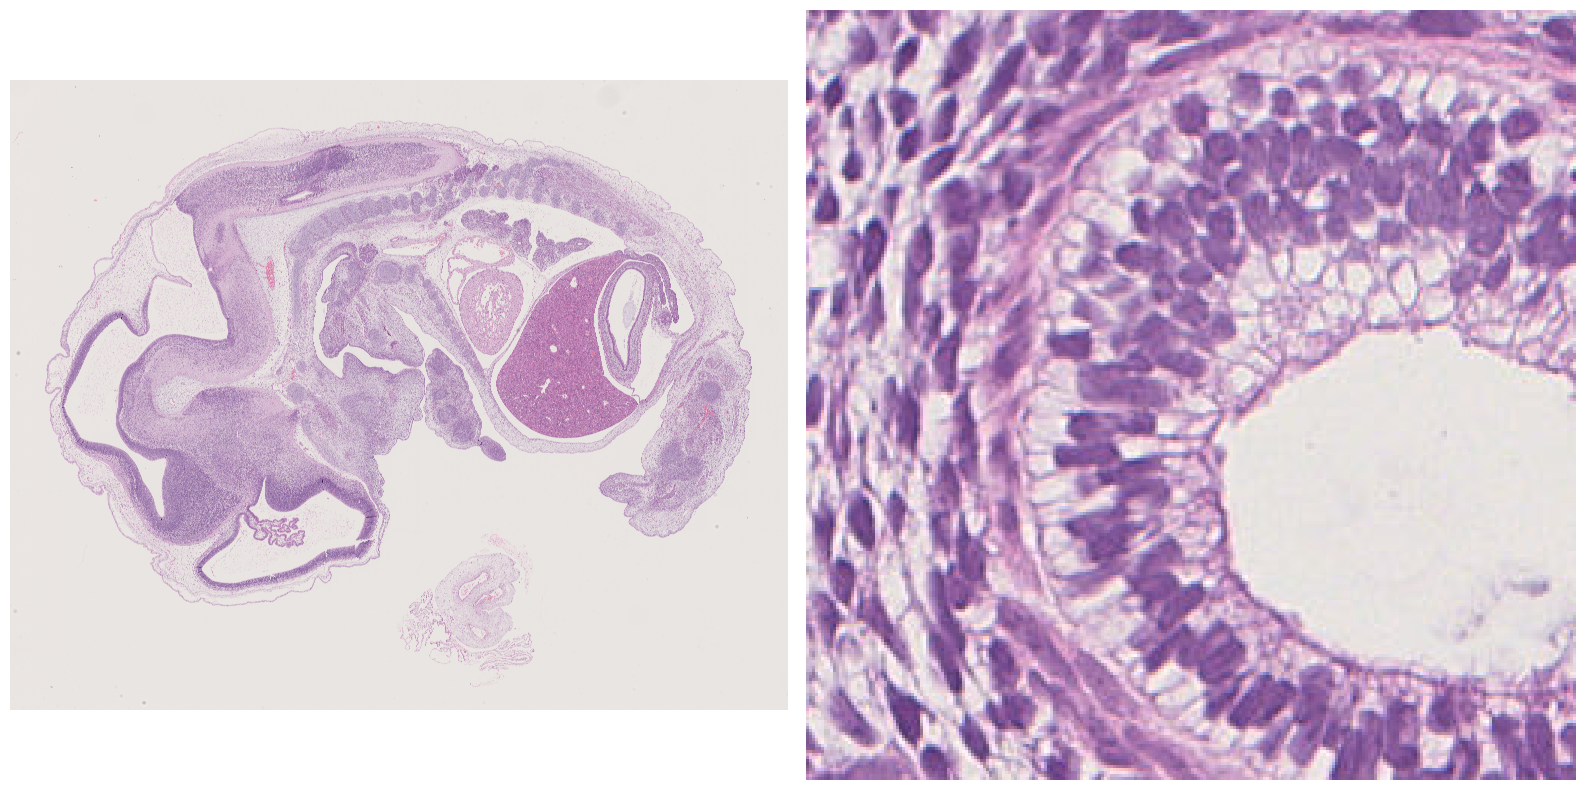

In [93]:
show_image(imgs[ind], crop_x, crop_y, tile_size)

In [94]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [95]:
import json
from stardist.models import Config2D

model = load_model(r"\\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40")

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5742374622613553, nms=0.3) 



In [96]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

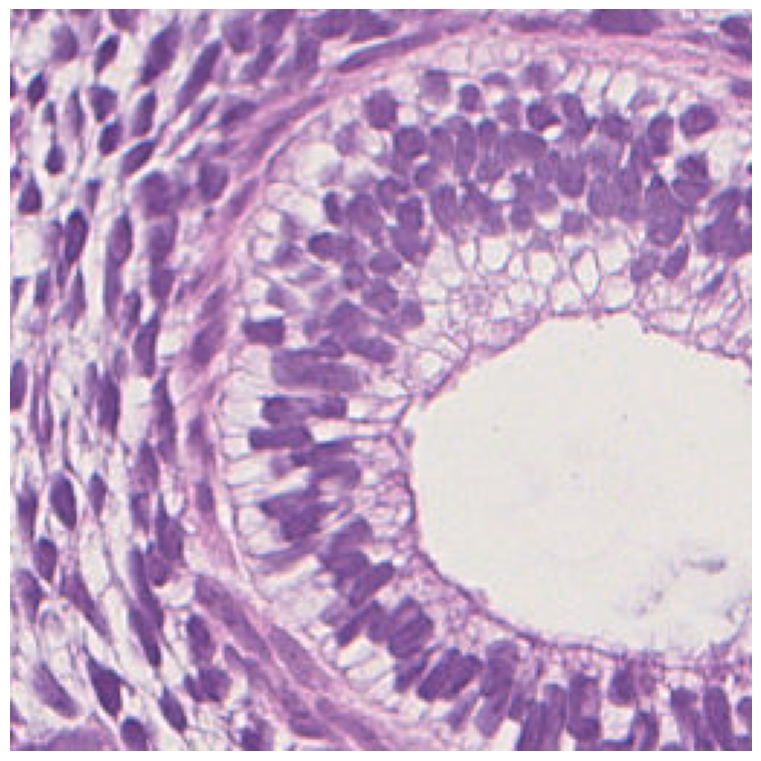

In [97]:
tiles_path = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\tiles256'
tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tif')]

tile = os.path.join(tiles_path, tiles[ind])
tile_im = imread(tile)

show_tile(tile_im)

In [98]:
full_tiles_path = []
for x in tiles:
    full_tiles_path.append(os.path.join(tiles_path, x))

full_tiles_path

['\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\new_tiles_11_3\\tiles256\\monkey_fetus_40_0371_Lung.tif',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\new_tiles_11_3\\tiles256\\monkey_fetus_40_0431_GI.tif',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\new_tiles_11_3\\tiles256\\monkey_fetus_40_0451_kidney.tif',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\new_tiles_11_3\\tiles256\\monkey_fetus_40_0507_Thyroid.tif',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\new_tiles_11_3\\tiles256\\monkey_fetus_40_0519_Ganglion.tif',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\new_tiles_11_3\\tiles256\\monkey_fetus_40_0532_heart.tif',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\new_tiles_11_3\\tiles256\\monkey_fetus_40_0612_brain.tif',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gest

In [99]:
from csbdeep.utils import Path, normalize
from stardist import fill_label_holes
from tqdm import tqdm  # progress bar class
from glob import glob

X = full_tiles_path
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

X = [x/255 for x in X]  # no norm, just divide by 255 to get into (0,1) range

Y_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X)]

100%|██████████| 9/9 [00:00<00:00, 11.42it/s]


In [100]:
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

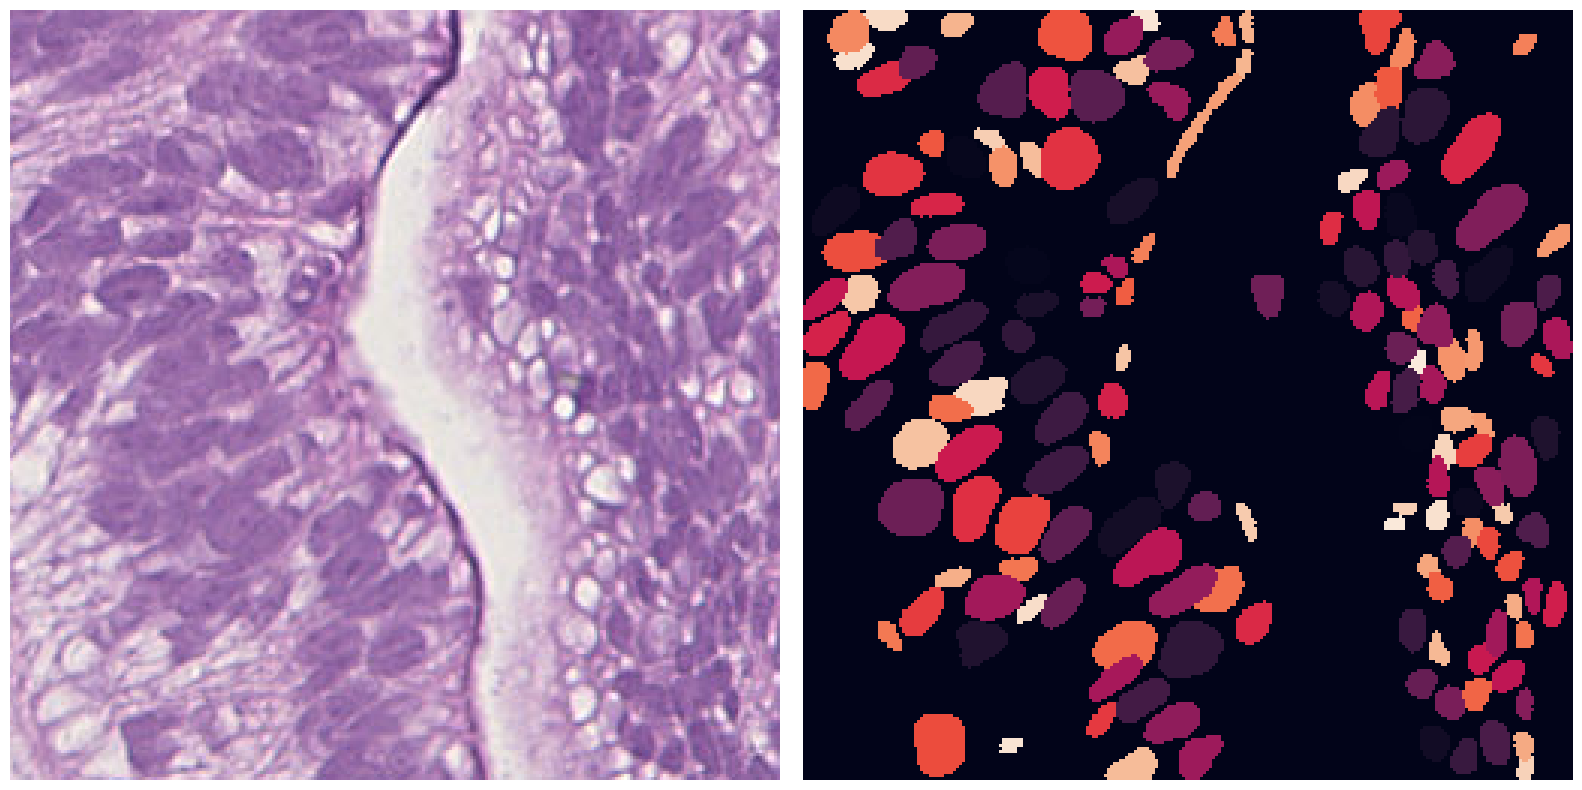

In [101]:
ind = 1

img = X[ind]
lbl = Y_pred[ind]

show_tile_segmented(img, lbl)

Now that we saw how it does on first tile, lets do it on all tiles and save

In [104]:
import json
import geojson
from pathlib import Path

# correct format for geojson export file (centroids, contours, etc.)
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

In [105]:
cc = 0

Finished monkey_fetus_40_0371_Lung.geojson


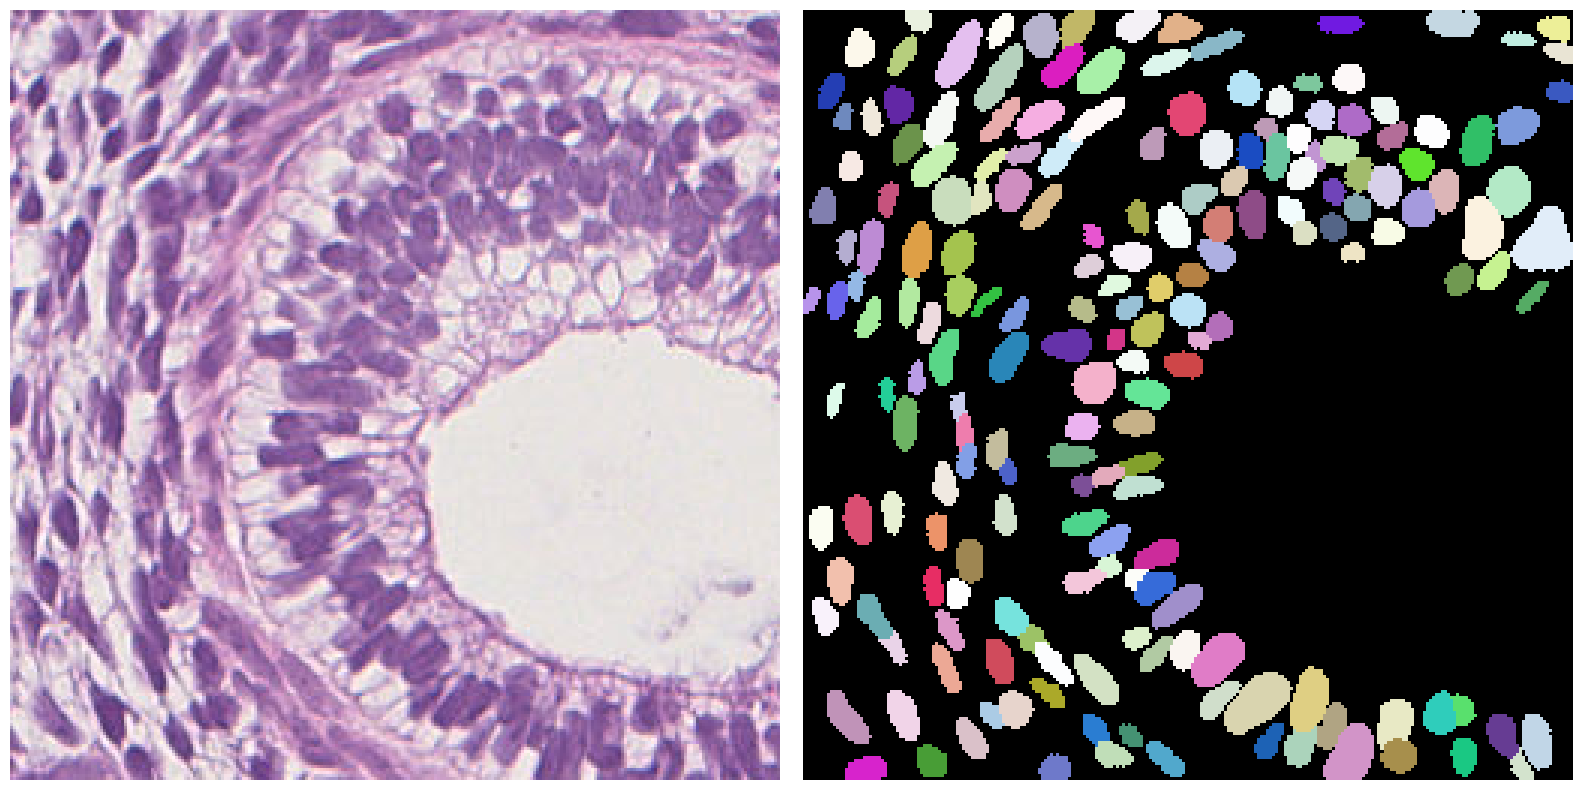

Finished monkey_fetus_40_0431_GI.geojson


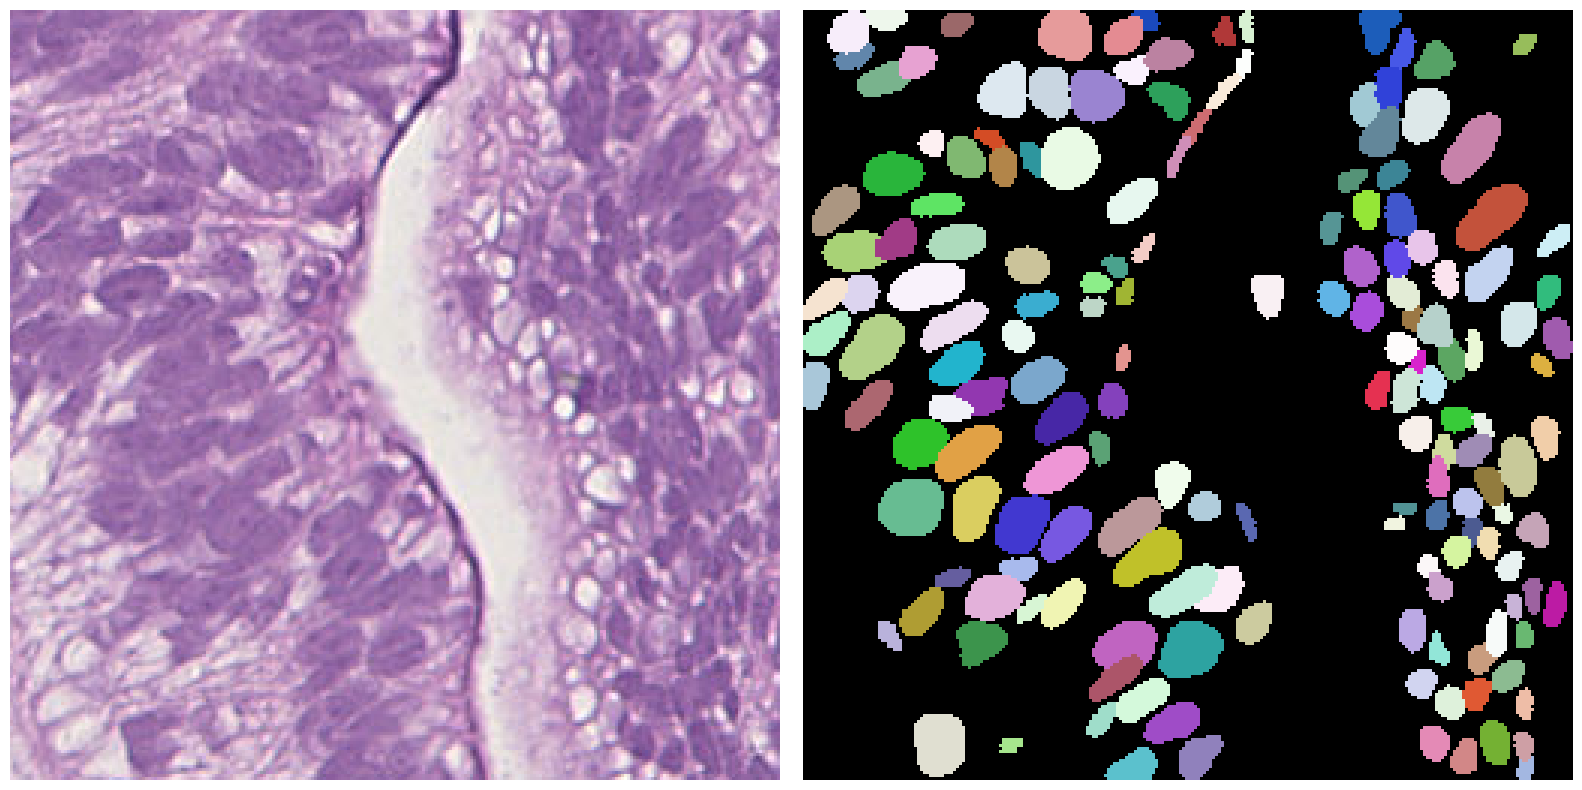

Finished monkey_fetus_40_0451_kidney.geojson


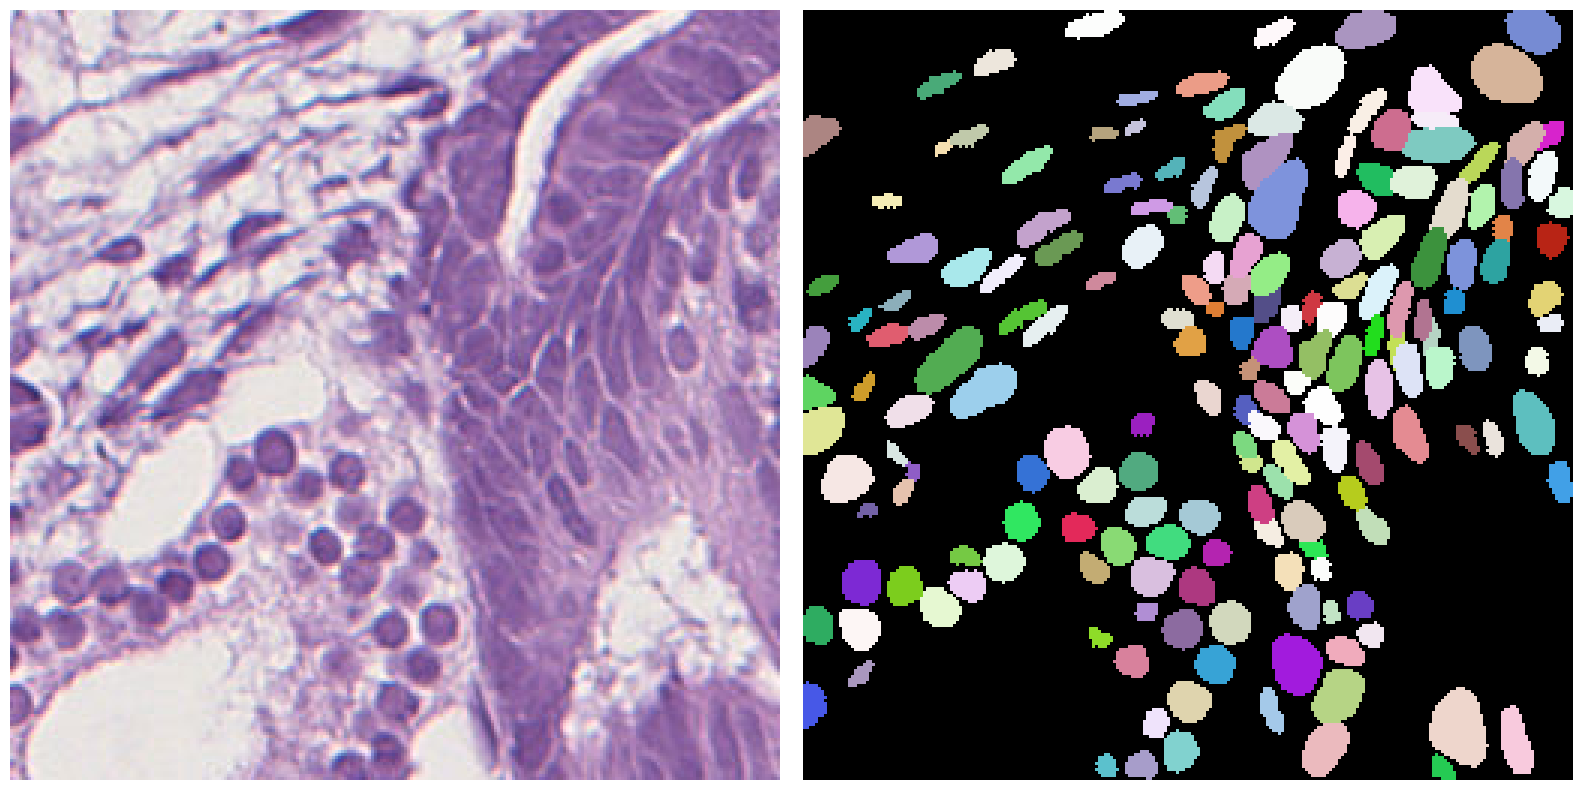

Finished monkey_fetus_40_0507_Thyroid.geojson


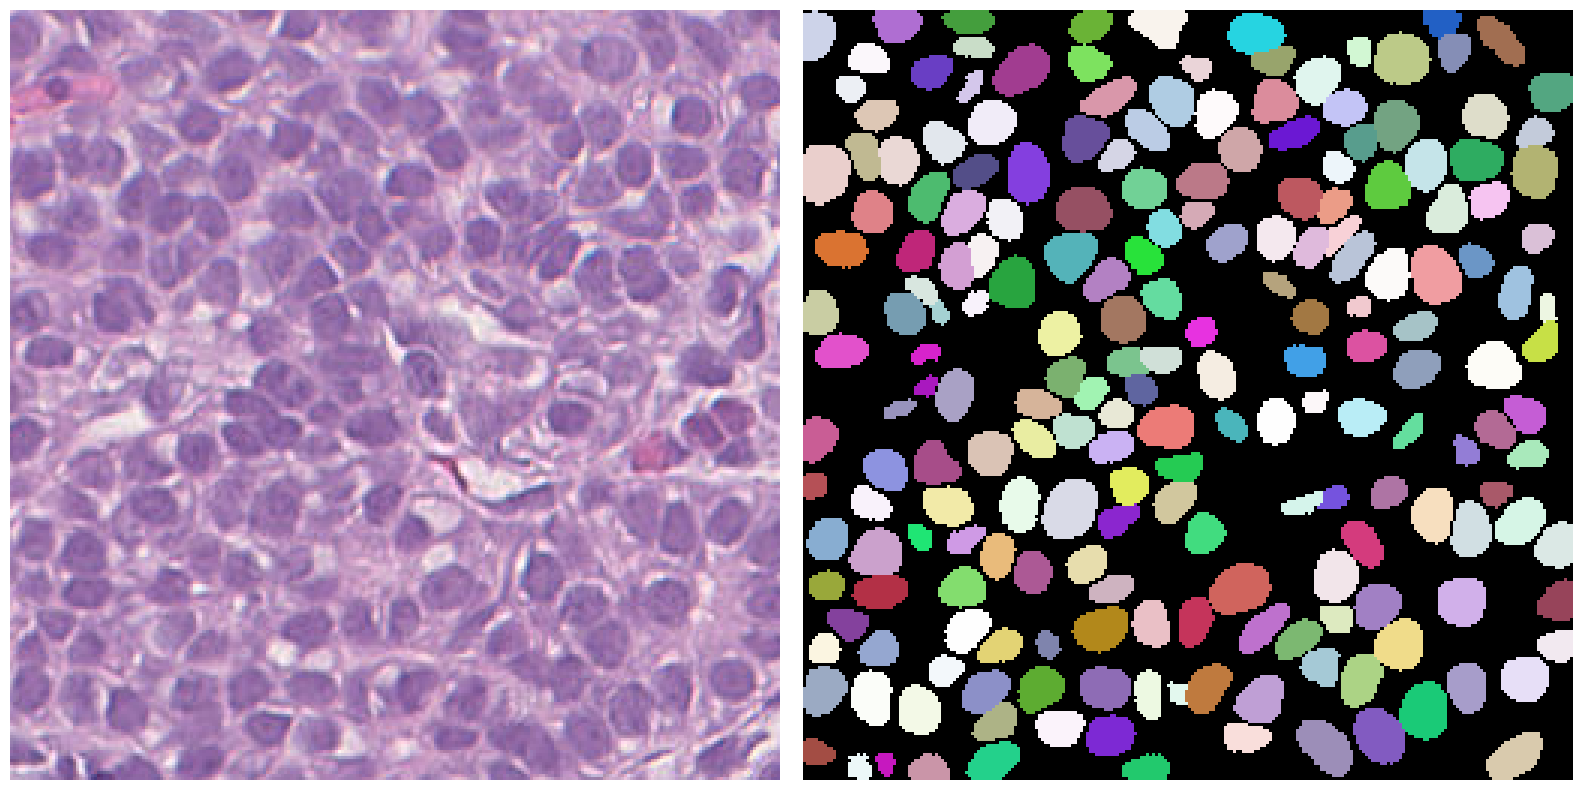

Finished monkey_fetus_40_0519_Ganglion.geojson


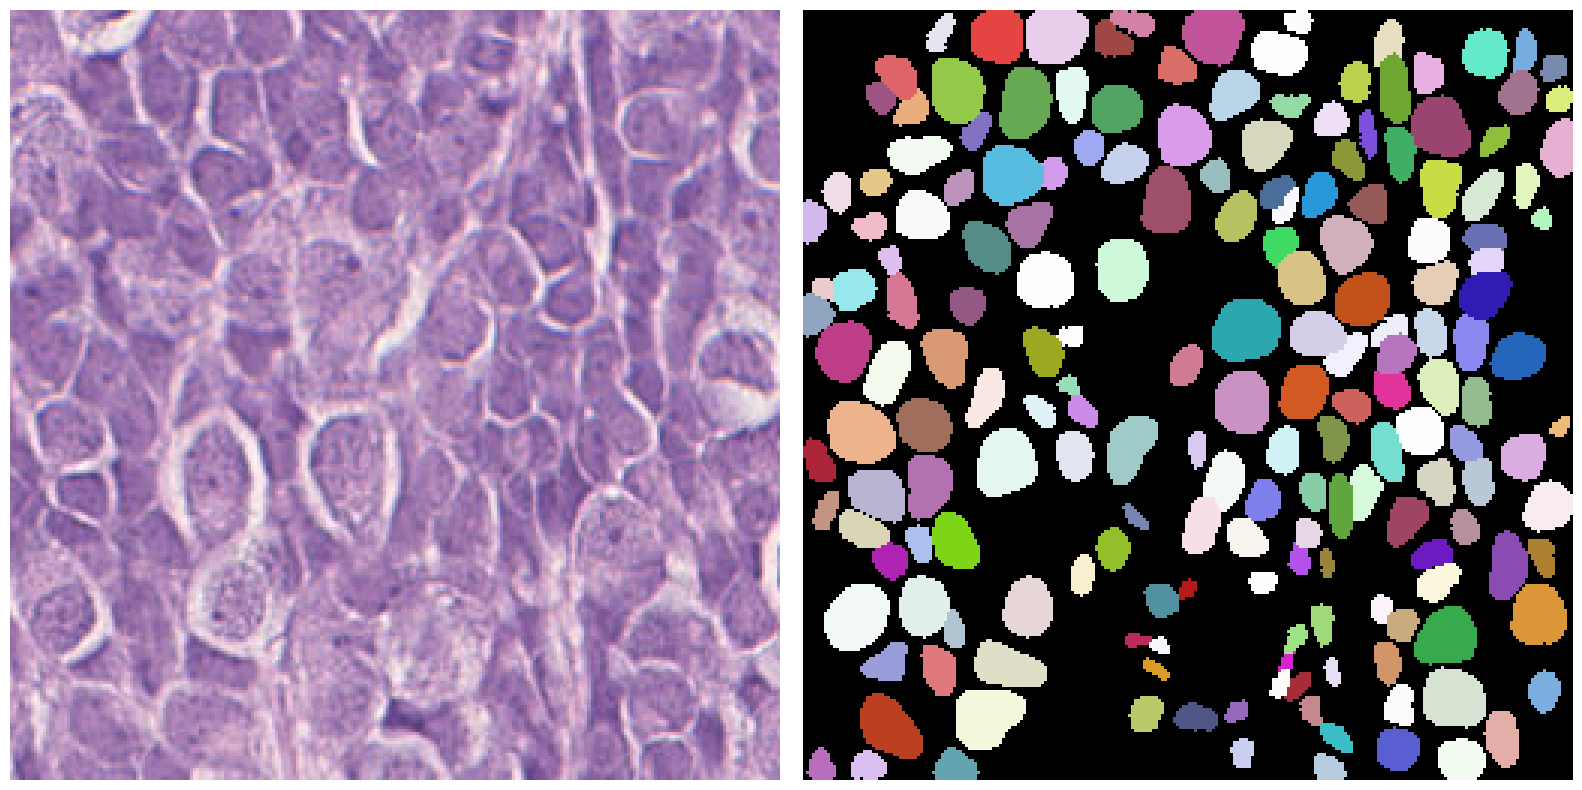

Finished monkey_fetus_40_0532_heart.geojson


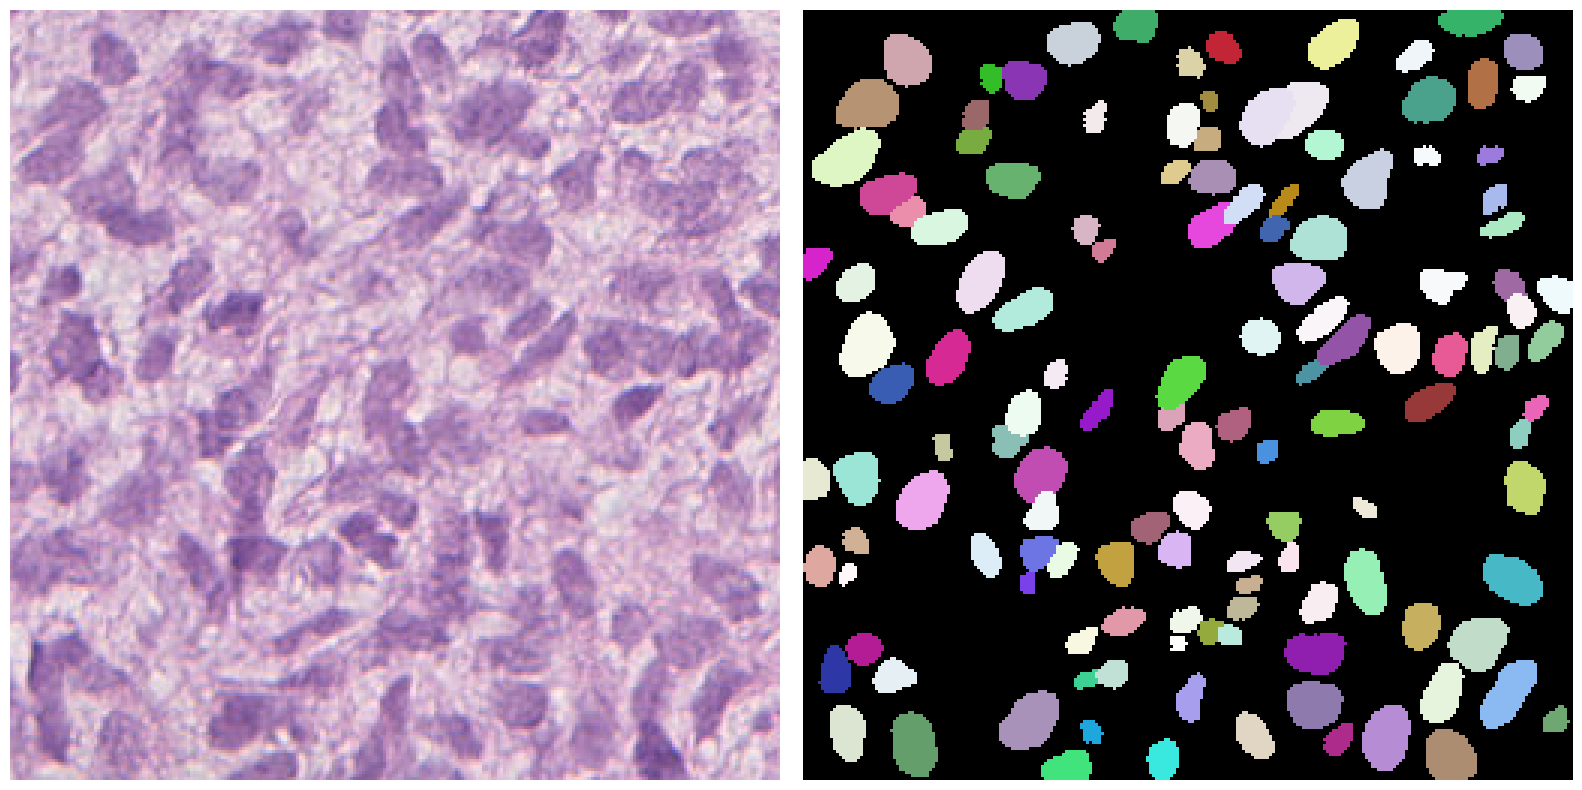

Finished monkey_fetus_40_0612_brain.geojson


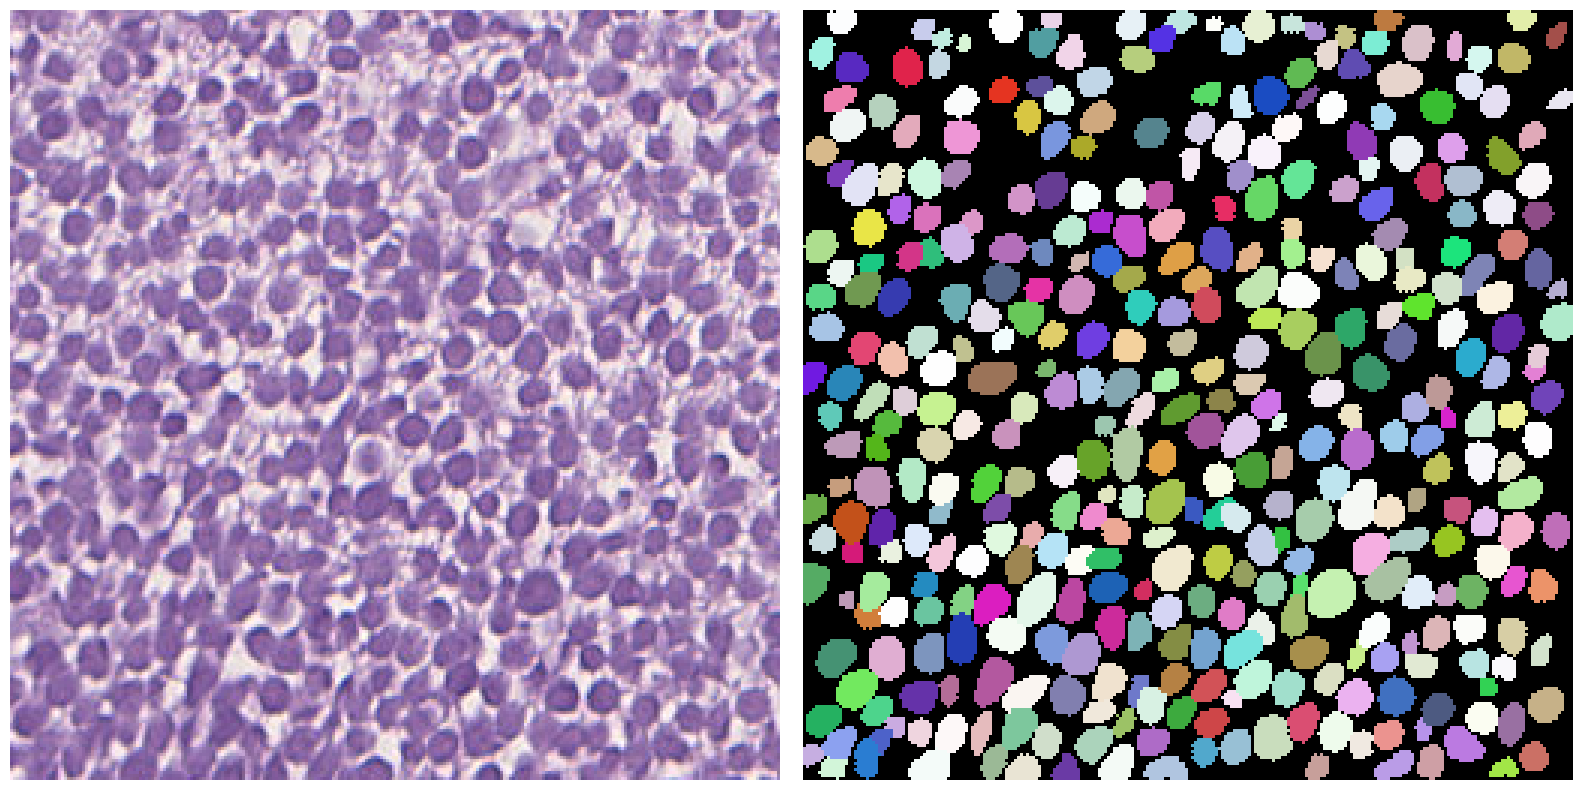

Finished monkey_fetus_40_0640_bone.geojson


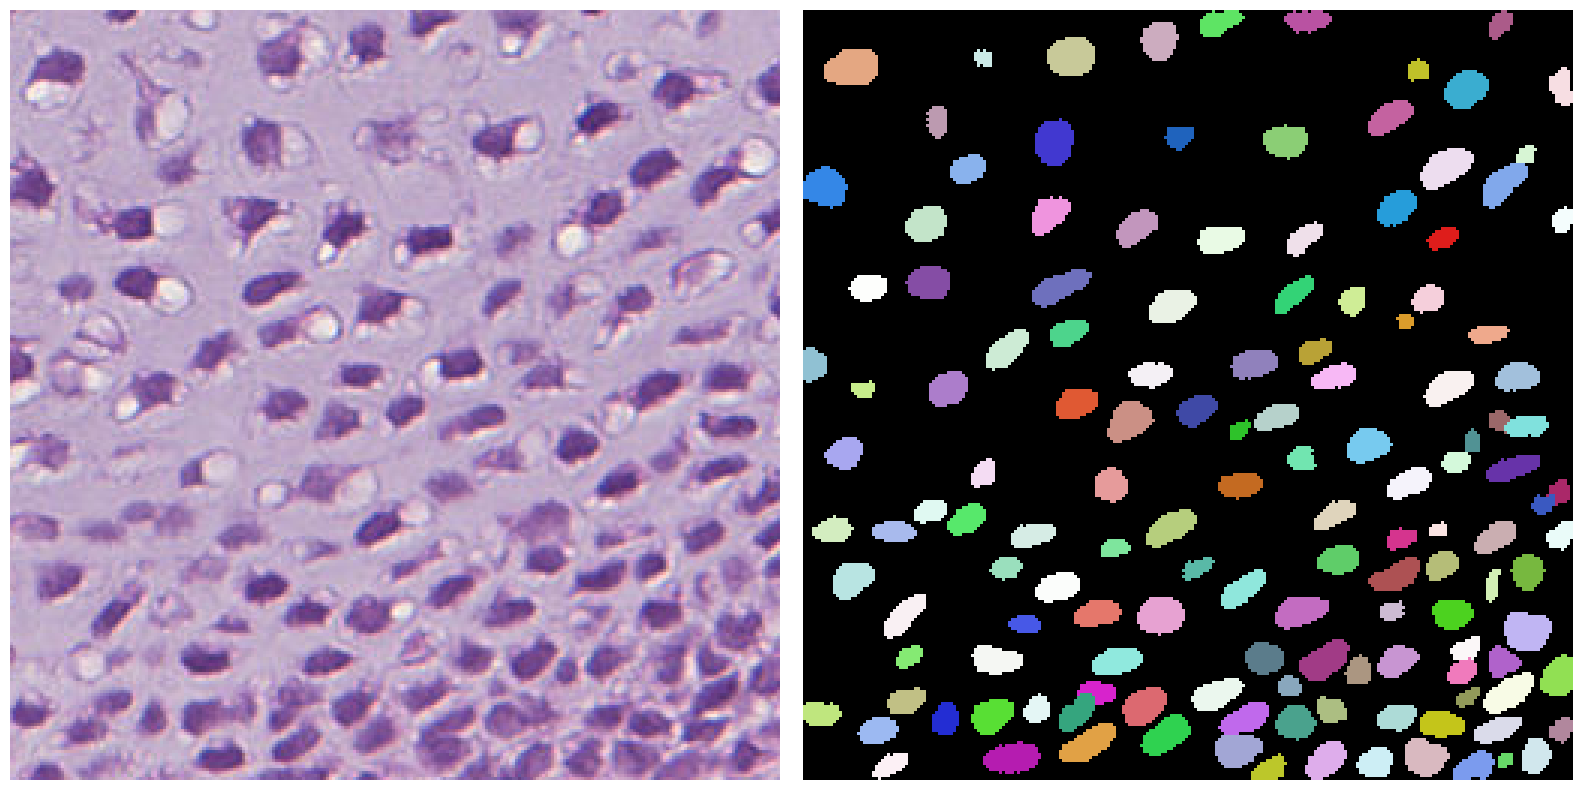

Finished monkey_fetus_40_0642_bone2.geojson


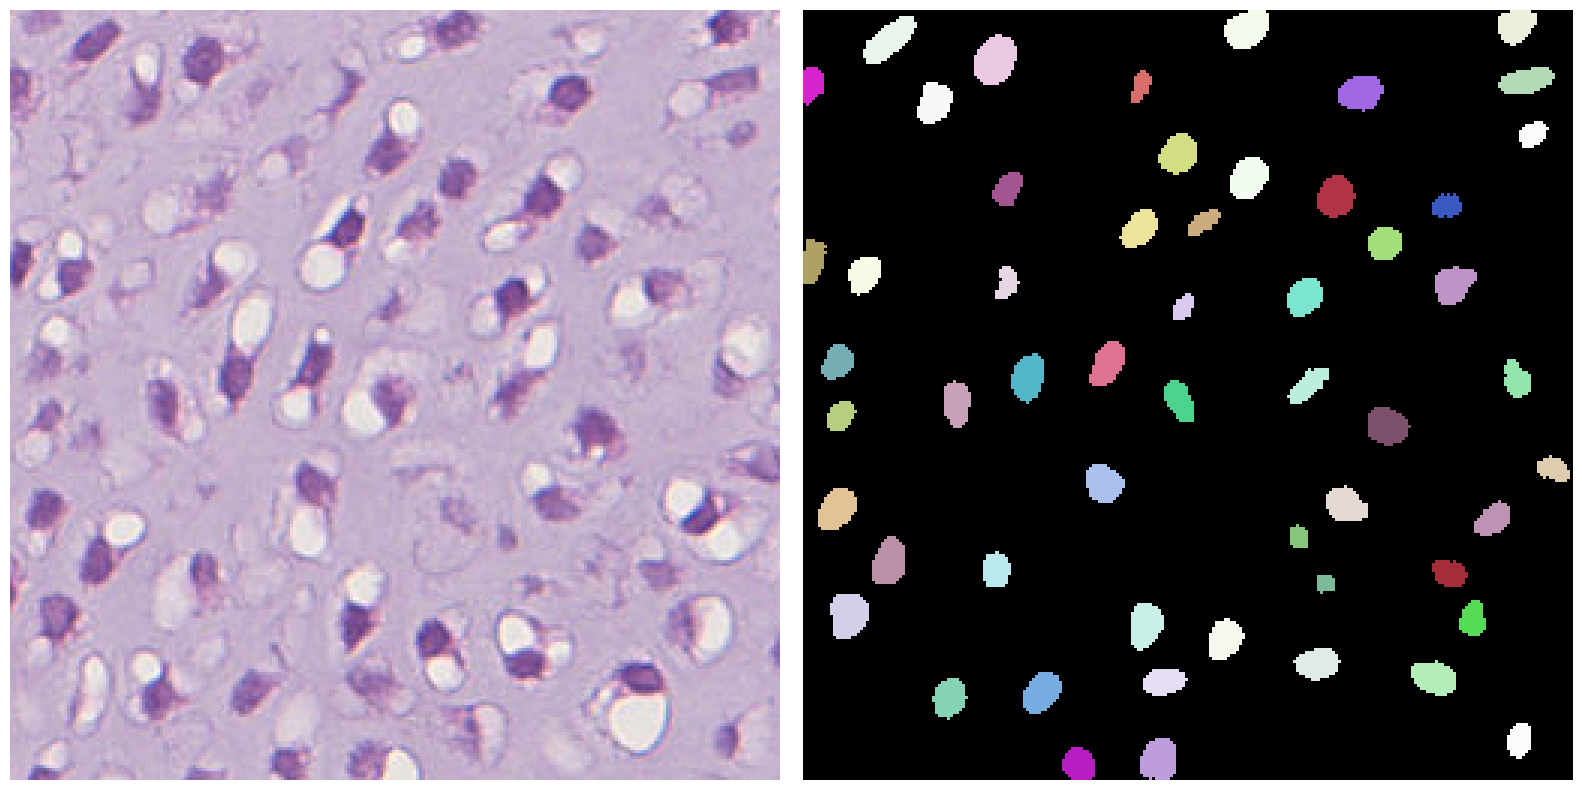

In [106]:
tiles_path = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\tiles256'
tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tif')]

tile = os.path.join(tiles_path, tiles[ind])

while cc < len(tiles):
    name = tiles[cc]
    tile_pth = os.path.join(tiles_path, name)
    tile = imread(tile_pth)

    tile = tile/255

    result = model.predict_instances(tile)

    # save centroids and contours in geojson format to import into qupath
    coords = result[1]['coord']
    # print(len(coords[0][0]))
    contours = []
    for xy in coords:
        contour = []
        for i in range(len(xy[0])):
            p = [xy[0][i], xy[1][i]]  # [x, y]
            contour.append(p)
        contours.append(contour)

    data_stardist = []
    for i in range(len(result[1]['points'])):
        nucleus = result[1]['points'][i]
        contour = contours[i]
        both = [nucleus, contour]
        data_stardist.append(both)

    GEOdata = []

    for centroid, contour in data_stardist:
        # xy coordinates are swapped, so I reverse them here with xy[::-1]
        contour = [[int(coord) for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
        contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

        # Create a new dictionary for each contour
        dict_data = {
            "type": "Feature",
            "id": "PathCellObject",
            "geometry": {
                "type": "Polygon",
                "coordinates": [contour]
            },
            "properties": {
                'objectType': 'annotation',
                'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
            }
        }

        GEOdata.append(dict_data)

    out_pth = Path(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\new_tiles_11_3\tiles256\stardist_segmented_jsons')
    new_fn = name[:-4] + '.geojson'

    with open(out_pth.joinpath(new_fn),'w') as outfile:
        geojson.dump(GEOdata,outfile)
    print('Finished',new_fn)

    cc += 1

    labels, polys = model.predict_instances(tile)
    show_tile_segmented(tile, labels, cmap = cmap)


In [ ]:
result = modbel.predict_instances(tile_im, normalizer=normalizer)

In [ ]:
coords = result[1]['coord']
# print(len(coords[0][0]))
contours = []
for xy in coords:
    contour = []
    for i in range(len(xy[0])):
        p = [xy[0][i], xy[1][i]]  # [x, y]
        contour.append(p)
    contours.append(contour)

print(len(contours))

In [ ]:
len(result[1]['points'])

In [ ]:
# combine points and contours into 1 list

data_stardist = []
for i in range(len(result[1]['points'])):
    nucleus = result[1]['points'][i]
    contour = contours[i]
    both = [nucleus, contour]
    data_stardist.append(both)

In [ ]:
for data in data_stardist:
    print(data)
    break

Now, need to format the points / contours into json format so that it can be read into Qupath for annotations

In [3]:
import json
import geojson
from pathlib import Path

ModuleNotFoundError: No module named 'geojson'

In [2]:
# correct format
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

NameError: name 'Path' is not defined

In [ ]:
info

In [ ]:
GEOdata = []

points = []
count = 0

for centroid, contour in data_stardist:
    # xy coordinates are swapped, so I reverse them here with xy[::-1]
    contour = [[int(coord) for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
    contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath
    points.append(centroid)

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)
    count += 1

print(count)

In [ ]:
for x in GEOdata:
    print(x)
    break

In [ ]:
# type(GEOdata[0])
type(GEOdata[0]['geometry']['coordinates'][0][0][0])

In [ ]:
print(GEOdata[:5])

In [ ]:
out_pth = Path(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons')
new_fn = WSIs[ind][:-5] + '.geojson'

print(new_fn)
with open(out_pth.joinpath(new_fn),'w') as outfile:
    geojson.dump(GEOdata,outfile)
print('Finished',new_fn)